test


In [3]:
# Импорт библиотек
import os
import time
import ASW
import GTU
import KU_TU
import mat_properties as prop
import numpy as n
import pandas as pd
import SP
from scipy.optimize import root

# таблица номинального режима
gas_streams0 = pd.read_excel("streams0.xlsx", sheet_name="gas", index_col=0)
water_streams0 = pd.read_excel("streams0.xlsx", sheet_name="water", index_col=0)
GTU_ISO = pd.read_excel("input.xlsx", sheet_name="ISO", index_col=0)
GTU_input = pd.read_excel("input.xlsx", sheet_name="GTU_input", index_col=0)
# рабочая таблица (=номинал в 1 итерации)
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
water_streams = pd.read_excel("streams.xlsx", sheet_name="water", index_col=0)
# рабочая таблица показателей блоков
heaters = pd.read_excel("blocks.xlsx", sheet_name="heaters", index_col=0)
electric = pd.read_excel("blocks.xlsx", sheet_name="electric", index_col=0)
accumulation = pd.read_excel("blocks.xlsx", sheet_name="accumulation", index_col=0)
# Состав газов в номинале
gasmix = "Nitrogen*Oxygen*CO2*Water*Argon"
# Считывание рефпропа
RP = prop.init_REFPROP(r"C:\Program Files (x86)\REFPROP")
fractiongas0 = (
    gas_streams0.at["GTU-PEVD", "N2"],
    gas_streams0.at["GTU-PEVD", "O2"],
    gas_streams0.at["GTU-PEVD", "CO2"],
    gas_streams0.at["GTU-PEVD", "H2O"],
    gas_streams0.at["GTU-PEVD", "Ar"],
)

gas0 = prop.Materials_prop(
    gasmix,
    fractiongas0,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)
water = prop.Materials_prop(
    "water",
    [1.0, 0, 0, 0, 0],
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)

# Задание энтальпий газа в номинальном режиме
Temperatures = gas_streams0.loc["GTU-KU":"GPK-out", "T"]
Pressure = gas_streams0.loc["GTU-KU", "P"]
Enthalpies = list(map(lambda x: gas0.p_t(Pressure, x)["h"], Temperatures))
gas_streams0.loc["GTU-KU":"GPK-out", "H"] = Enthalpies



# Состав газов при частичной нагрузке
fractiongas = (
    gas_streams.at["GTU-PEVD", "N2"],
    gas_streams.at["GTU-PEVD", "O2"],
    gas_streams.at["GTU-PEVD", "CO2"],
    gas_streams.at["GTU-PEVD", "H2O"],
    gas_streams.at["GTU-PEVD", "Ar"],
)
gas1 = prop.Materials_prop(
    gasmix,
    fractiongas,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)

# Основные константы
Calcmethod = "hybr"
KPD_PN = 0.8074
KPD_KN = 0.75
KPD_to = 0.99
KPD_SP = 0.99

Calctolerance = 10**-2
Teplo = 1
Maxiterations_KU_TU = 20
Maxiterations_cotel = 4
Maxiterations_turbine = 30
steamVD_fraction_to_turbine=1
steamVD_to_turbine=0

#--------------------------------- ВАРЬИРУЕМЫЕ ПАРАМЕТРЫ
# Задаем нагрузку
GTU_input.at["n", 1] = 1
GTU_input.at["tair", 1] = 7
vremya = 4
 # # Выбор происходит ли зарядка : 1 - заряжается, 2 - разряжается, любое другое число - не участвует в расчете
ASWbul = 1
#----------------------------------------------------------
# print(GTU_input)
############################################################
# Теплосеть
gas_streams.loc["AIR", "T":"P"] = [GTU_input.loc["tair", 1], 0.1]
water_streams.loc["AIR", "T":"P"] = [GTU_input.loc["tair", 1], 0.1]
Tnv = gas_streams.at["AIR", "T"]
water_streams.at["SWIN-TURB", "T"] = SP.Tset(Tnv)[1]
water_streams.at["SP2-WOUT", "T"] = SP.Tset(Tnv)[0]

water_streams.at["SWOUT", "T"] = SP.Tset(Tnv)[0]
water_streams.at["SWIN", "T"] = SP.Tset(Tnv)[1]
# print(water_streams)
############################################################
#--------------------------------Расчет ГТУ
Gas_turbine = GTU.gtu(GTU_ISO, GTU_input, "GTU-KU")
Gas_turbine_res = Gas_turbine.calc()
electric.at["GTU", "N"] = Gas_turbine_res["N"]
electric.at["GTU", "KPD"] = Gas_turbine_res["eff"]
electric.at["DK", "N"] = Gas_turbine_res["Ndk"]
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
gas_streams.at["GTU-KU", "T"] = Gas_turbine_res["T"]
gas_streams.at["GTU-KU", "G"] = Gas_turbine_res["G"]
gas_streams.at["GTU-KU", "P"] = 0.1
gas_streams.at["GTU-KU", "H"] = gas0.p_t(
    gas_streams.at["GTU-KU", "P"], gas_streams.at["GTU-KU", "T"]
)["h"]
Gas_turbine_composition = pd.read_excel(
    "input.xlsx", sheet_name="Gas_composition0", index_col=0
)

# Параметры газа на выходе в КУ
gas_streams.loc["GTU-PEVD", "T":"P"] = gas_streams.loc["GTU-KU", "T":"P"]
gas_streams.at["GTU-PEVD", "G"] = gas_streams.loc["GTU-KU", "G"]
gas_streams.loc["GTU-PEVD", "N2":"Ar"] = Gas_turbine_composition.loc[
    "Fraction", "N2":"Ar"
]
#--------------------------------------------------------------------------
# Class KU+TU
KU_and_TU = KU_TU.ku_tu(
    gas0,
    gas1,
    water,
    gas_streams0,
    gas_streams,
    water_streams0,
    water_streams,
    heaters,
    electric,
    "PEVD-DROSVD",
    "PPND-DROSND",
    "DROSVD-TURBVD",
    "DROSND-TURBND",
    Calcmethod,
    KPD_SP,
    KPD_KN,
    KPD_to,
    KPD_PN,    
    steamVD_fraction_to_turbine,
    steamVD_to_turbine,
)

ASW = ASW.Accum(water,water_streams,accumulation,
                 stream12 = "ASW-WOUT",
                 stream11 = "SP2-ASW",
                 stream_obratnoi_setevoi_vody = "SWIN-TURB",
                 stream_pryamoi_setevoi_vody = "SP2-WOUT",
                 T_nar_vozd = water_streams.at["AIR", "T"])

ASW.set_construct(Diametr=2,
                   kolichestvo = 10,
                   Visota = 10,
                   lambda_min_vata = 0.045,
                   delta_min_vata = 0.01)

start_time = time.time()



    # # если Зарядка 
if ASWbul == 1:
    G_ASW_zarydka = ASW.zaryadka(vremya)['G']
    water_streams.at["SWIN-TURB", "G"] = water_streams.at["SWIN", "G"] + G_ASW_zarydka
    water_streams.at["SP2-WOUT", "G"] = water_streams.at["SWIN", "G"] + G_ASW_zarydka
        ## если разрядка
if ASWbul == 2:
    ASW.zaryadka(vremya)
    ASW.jdat(12)
    G_ASW_razryadka = ASW.razryadka(vremya)['G']
    water_streams.at["SWIN-TURB", "G"] = water_streams.at["SWIN", "G"] - G_ASW_razryadka
    water_streams.at["SP2-WOUT", "G"] = water_streams.at["SWIN", "G"] - G_ASW_razryadka
    water_streams.at["SWOUT", "H"] = water.p_t(water_streams.at["SWOUT","P"],water_streams.at["SWOUT", "T"])['h']
    water_streams.at["SP2-WOUT", "H"] = (water_streams.at["SWOUT", "H"]*water_streams.at["SWOUT", "G"] -
                                        water_streams.at["ASW-WOUT", "H"]*G_ASW_razryadka)/(water_streams.at["SWOUT", "G"]-G_ASW_razryadka)
    water_streams.at["SP2-WOUT", "T"] = water.p_h(water_streams.at["SP2-WOUT", "P"],water_streams.at["SP2-WOUT", "H"])['T']

KU_and_TU.calculate(
    Teplo,
    Calctolerance,
    Maxiterations_KU_TU,
    Maxiterations_cotel,
    Maxiterations_turbine,
)

print(
    "Степень сухости пара в ЭВД: ",
    water.p_h(water_streams.at["EVD-IVD", "P"], water_streams.at["EVD-IVD", "H"])["Q"],
)
print(
    "Степень сухости пара в ГПК: ",
    water.p_h(water_streams.at["GPK-IND", "P"], water_streams.at["GPK-IND", "H"])["Q"],
)

print(f"fin КУ и ТУ:--- {round((time.time() - start_time), 1)} сек. ---")
electric

67573479.75379118
Достигнуто максимальное количество итераций контура высокого давления
Fin котел-утилизатора:--- 4.23 сек. ---
dQ/Qsumm 0.07551579571003175
Fin турбоустановка:--- 0.05 сек. ---
Достигнуто максимальное количество итераций контура низкого давления
Достигнуто максимальное количество итераций контура низкого давления
Достигнуто максимальное количество итераций контура низкого давления
Повышена точность расчета котла для увеличения сходимости
dQ/Q ПЕВД+ИВД+ЭВД 2.5605848670382727
dQ/Q ПЕВД+ИВД+ЭВД -1.4729720859768056
dQ/Q ПЕВД+ИВД+ЭВД 0.7166022004702418
dQ/Q ПЕВД+ИВД+ЭВД -0.35390927798321775
Достигнуто максимальное количество итераций контура высокого давления
dQ/Q ППНД+ИНД+ГПК 0.4755715270600454
dQ/Q ППНД+ИНД+ГПК -0.08264631129767279
Достигнуто максимальное количество итераций котла-утилизатора
Fin турбоустановка:--- 0.04 сек. ---
Достигнуто максимальное количество итераций контура высокого давления
Достигнуто максимальное количество итераций контура низкого давления
Достиг

Fin котел-утилизатора:--- 1.54 сек. ---
dQ/Qsumm -0.0038869272317816404
Fin турбоустановка:--- 0.29 сек. ---
Fin котел-утилизатора:--- 1.02 сек. ---
dQ/Qsumm 0.002193921961707081
Fin турбоустановка:--- 0.13 сек. ---
Максимальная погрешность определения расхода в КУ+ПТУ 0.008025134749847278
Pnd_it [0.6942, 0.66629, 0.66032, 0.65006, 0.64661, 0.64551, 0.6452, 0.64507, 0.64508, 0.64504]
Pvd_it [8.40651, 8.33977, 8.30924, 8.34477, 8.35937, 8.36509, 8.36714, 8.36852, 8.36909, 8.36909]
Время 10 итерации расчета КУ+ТУ:--- %s сек. --- 136.2
Fin котел-утилизатора:--- 1.03 сек. ---
dQ/Qsumm -0.0015330041466795614
Fin турбоустановка:--- 0.25 сек. ---
Максимальная погрешность определения расхода в КУ+ПТУ 0.003963309609241198
Pnd_it [0.6942, 0.66629, 0.66032, 0.65006, 0.64661, 0.64551, 0.6452, 0.64507, 0.64508, 0.64504, 0.64503]
Pvd_it [8.40651, 8.33977, 8.30924, 8.34477, 8.35937, 8.36509, 8.36714, 8.36852, 8.36909, 8.36909, 8.36929]
Время 11 итерации расчета КУ+ТУ:--- %s сек. --- 137.5
Максимальна

,Ni,N,KPDm,KPD
PEN,0.696179,0.713261,0.976052,0.807400
CVD,NaN,NaN,NaN,NaN
CND,NaN,NaN,NaN,NaN
GTU,NaN,157.979400,NaN,33.745787
DK,NaN,6.285084,NaN,NaN
Turbine,57.637988,NaN,NaN,NaN
Tots1,37.396973,NaN,NaN,0.848254
Tots2,15.016584,NaN,NaN,0.680250
Tots3,0.103407,NaN,NaN,0.642066
Tots4,5.121024,NaN,NaN,0.104144


In [14]:
# Вывод газовых потоков
gas_streams

,T,P,H,G,N2,O2,CO2,H2O,Ar
AIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-KU,542.010558,0.1,958.533980,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
REF-SMESH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-PEVD,542.010558,0.1,958.533980,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,467.876459,0.1,873.835241,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,308.238105,0.1,696.367808,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,234.018389,0.1,616.058514,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,231.164948,0.1,612.996234,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,172.173929,0.1,550.064291,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,100.896473,0.1,474.849236,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065


In [15]:
# Вывод водяных потоков
water_streams

,T,P,H,G,S,X
AIR,15.000000,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,511.596294,8.287661,3424.823602,62.480161,NaN,NaN
IVD-PEVD,300.282022,8.622078,2749.094505,62.480161,NaN,NaN
EVD-IVD,297.952573,8.622078,1333.268065,62.480161,NaN,NaN
PEN-EVD,162.870215,8.622078,692.563696,62.480161,NaN,NaN
BND-PEN,161.093872,0.635626,680.227710,62.480161,NaN,NaN
PPND-DROSND,206.807762,0.629934,2863.977217,14.489382,NaN,NaN
IND-PPND,161.093872,0.635626,2758.638621,14.489382,NaN,NaN
GPK-IND,157.335489,0.635626,663.942985,76.969543,NaN,NaN
GPK-REC,157.335489,0.635626,663.942985,90.945484,NaN,NaN


In [4]:
Errors_water = abs(water_streams - water_streams0) / water_streams0 * 100
Errors_gas = abs(gas_streams - gas_streams0) / gas_streams0 * 100
Errors_gas
Errors_water

,G,H,P,S,T,X
AIR,NaN,NaN,NaN,NaN,53.333333,NaN
ASW-OD,NaN,NaN,NaN,NaN,NaN,NaN
ASW-WOUT,NaN,NaN,NaN,NaN,NaN,NaN
BND-PEN,0.171389,1.710428,6.604922,NaN,1.659392,NaN
DOOTB1,49.695847,5.297021,82.714910,5.411792,NaN,NaN
DOOTB2,0.130323,3.100643,60.048689,2.737375,23.867449,NaN
DROSND-TURBND,1.426294,0.223160,8.857777,0.402960,1.996935,NaN
DROSVD-ST,NaN,NaN,NaN,NaN,NaN,NaN
DROSVD-TURBVD,0.171389,0.215106,0.458216,NaN,0.622305,NaN
ENDOFVD,0.171389,0.702729,10.182556,NaN,5.427191,NaN


In [5]:
gas_streams0

,T,P,H,G,N2,O2,CO2,H2O,Ar
AIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-KU,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
REF-SMESH,NaN,NaN,-9999.990000,NaN,NaN,NaN,NaN,NaN,NaN
GTU-PEVD,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,468.05,0.1,874.031830,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,309.20,0.1,697.417326,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,235.90,0.1,618.078812,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,233.00,0.1,614.965387,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,175.50,0.1,553.594555,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,106.90,0.1,481.155410,503.8,0.7803,0.1237,0.0301,0.0594,0.0065


In [6]:
electric

,Ni,N,KPDm,KPD
PEN,0.696077,0.713171,0.976031,0.807400
CVD,NaN,NaN,NaN,NaN
CND,NaN,NaN,NaN,NaN
GTU,NaN,157.979400,NaN,33.745787
DK,NaN,6.285084,NaN,NaN
Turbine,57.765884,NaN,NaN,NaN
Tots1,37.396693,NaN,NaN,0.848245
Tots2,15.003874,NaN,NaN,0.679116
Tots3,0.299217,NaN,NaN,0.618197
Tots4,5.066100,NaN,NaN,0.188445


In [7]:
accumulation

,Qw,T
ASW,NaN,NaN


In [8]:
heaters

,Qw,Qg,KPD
PEVD,42246.161676,42672.890582,0.99
IVD,89166.431705,90067.102732,0.99
EVD,40741.674701,41153.206769,0.99
PPND,1577.833189,1593.770897,0.99
IND,32365.101508,32692.021725,0.99
GPK,38822.159156,39214.302177,0.99
SP2,85.873923,NaN,0.99
SP1,74.629808,NaN,0.99
OD,6.568773,NaN,0.99
NaN,NaN,NaN,NaN


In [9]:
GTU_input

,1,2,3,4,5,6
tair,7,NaN,NaN,NaN,NaN,NaN
n,1,NaN,NaN,NaN,NaN,NaN
Pin,0,NaN,NaN,NaN,NaN,NaN
Pout,0,NaN,NaN,NaN,NaN,NaN


,T,P,H,G,S,X
AIR,7.000000,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,508.076901,8.368546,3415.163398,63.291339,6.727289,NaN
IVD-PEVD,300.987142,8.707977,2747.717569,63.291339,NaN,NaN
EVD-IVD,298.959500,8.707977,1338.902503,63.291339,NaN,NaN
PEN-EVD,163.466390,8.707977,695.187333,63.291339,NaN,NaN
BND-PEN,162.004706,0.650403,684.189350,63.291339,NaN,NaN
PPND-DROSND,207.614912,0.644491,2865.019057,14.970521,6.966586,NaN
IND-PPND,162.004706,0.650403,2759.625834,14.970521,NaN,NaN
GPK-IND,158.182746,0.650403,667.619035,78.261860,NaN,NaN
GPK-REC,158.182746,0.650403,667.619035,93.342857,NaN,NaN


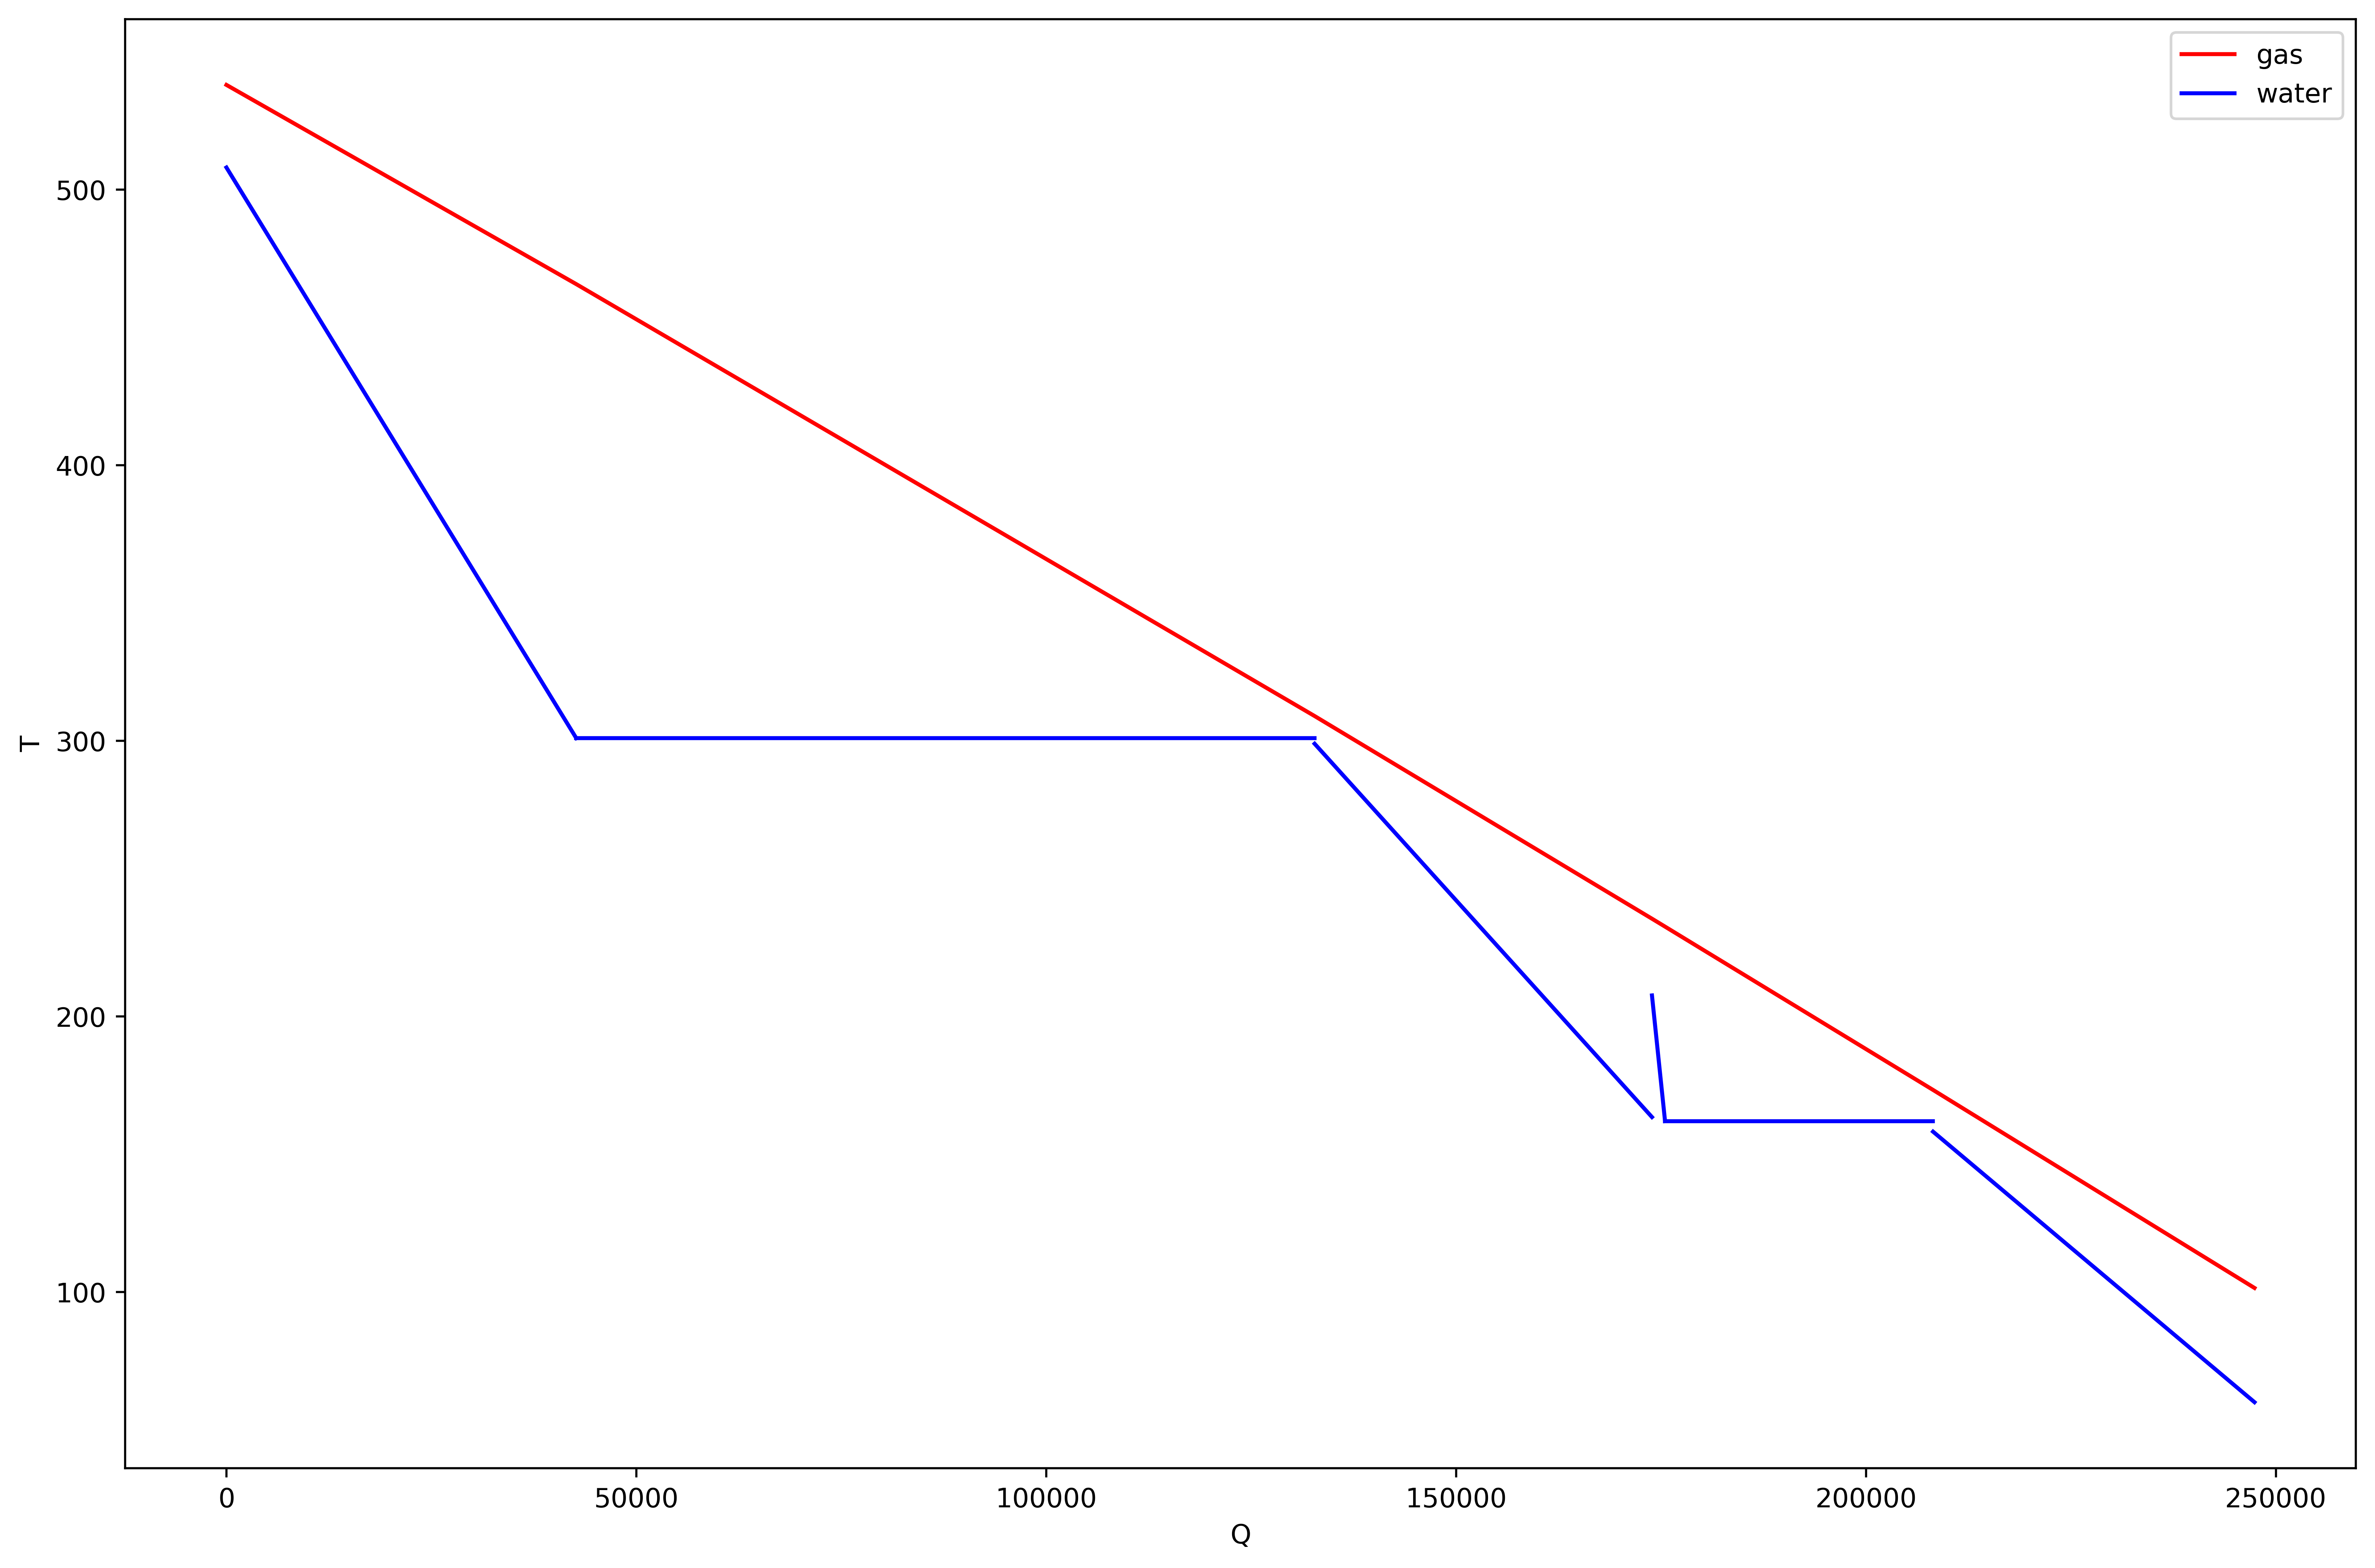

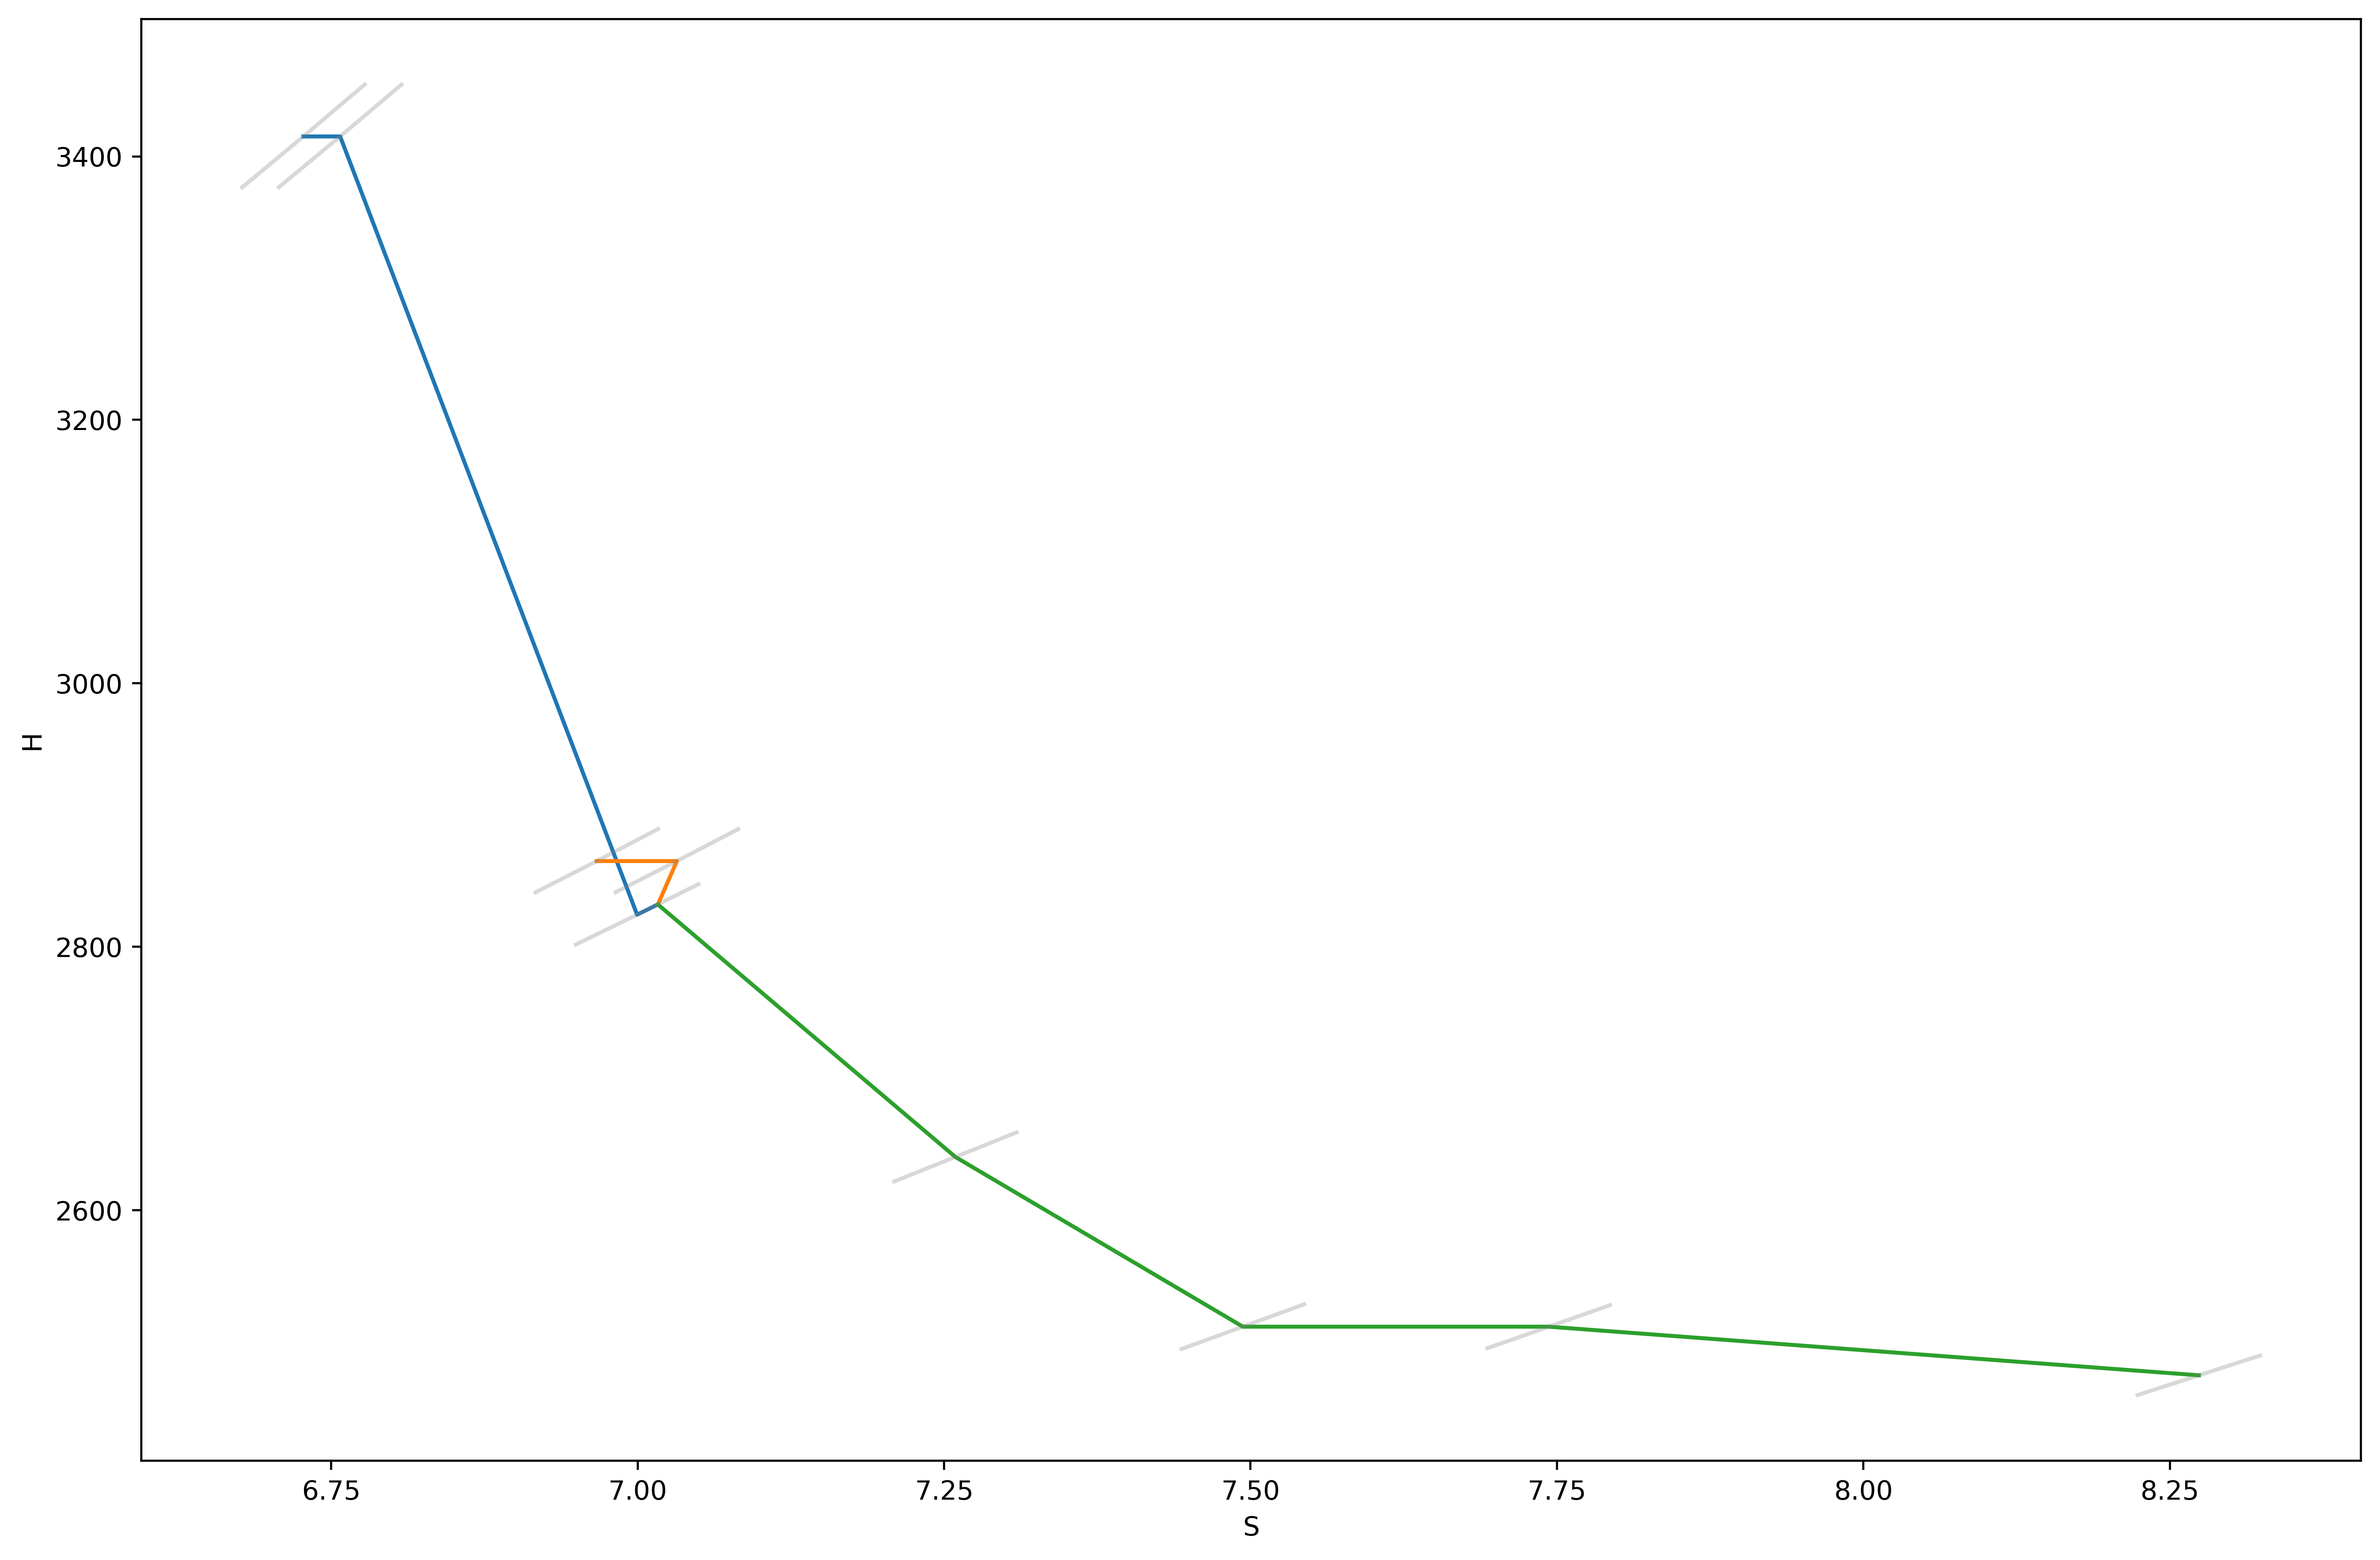

In [10]:
import Grafiki

Grafiki.Q_t_diagram(gas_streams, water_streams, heaters, 15, 10)
Grafiki.H_S_diagram(water, water_streams, 15, 10)
water_streams